In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
datadir = r"D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/PeakWithML/Data/sampleData_1.0/"

Note that the data is preliminary and may have some errors. However, the shapes and structures should be a good representation of the data. 

In [4]:
prof = pd.read_csv(os.path.join(datadir, "profiles.csv"))
spect = pd.read_csv(os.path.join(datadir, "spectra.csv"))
cpTH = np.load(os.path.join(datadir, "cpdata.npy"))
cpstats = pd.read_csv(os.path.join(datadir, "cpstats.csv"))

## Data Structure

The inputs are **Profile**, **Spectra**, and **Cp time history**. The output is a matrix containing the **Cp statistics**. The profile and spectra have fixed sizes, but the Cp time history has fixed size for its second dimension (i.e., time). The first dimension of the Cp time history is variable and depends on the number of Cp measurements. The Cp statistics matrix follows the number of Cp measurements as a first dimension and the number of statistics as a second dimension.

In the current data set, 1320 is the number of 'examples'. In the future, we will expand the dataset to include more examples. We will have cases with different set of inputs, including change of wind field.

In [24]:
print("INPUTS:")
print(f"Shape of prof: {prof.shape}")
print(f"Shape of spect: {spect.shape}")
print(f"Shape of cpTH: {cpTH.shape}")

print("\nOUTPUTS:")
print(f"Shape of all cpstats: {cpstats.shape}")
print(f"Shape of output for the ML: {(cpstats.shape[0], 8)}  (does not need to predict 'minCp', and 'maxCp')")

print(f"\nThe data expantion is done by growing {cpTH.shape[0]}.")

INPUTS:
Shape of prof: (100, 9)
Shape of spect: (1000, 4)
Shape of cpTH: (1320, 40000)

OUTPUTS:
Shape of all cpstats: (1320, 10)
Shape of output for the ML: (1320, 8)  (does not need to predict 'minCp', and 'maxCp')

The data expantion is done by growing 1320.


# Inputs

## Profiles
We have eight normalized profiles, all a function of normalized vertical height $Z/H$, where $H$ is the reference height of the structure (e.g., building height). They are:
* Velocity, $U/U_h$
* Longitudinal turbulence intensity, $I_u$
* Transversal turbulence intensity, $I_v$
* Vertical turbulence intensity, $I_w$
* Primary Reynolds shear stress, $\frac{\overline{u'w'}}{U_h^2}$
* Longitudinal integral length scale, $^xL_u/U_h$
* Transversal integral length scale, $^xL_v/U_h$
* Vertical integral length scale, $^xL_w/U_h$

All the profiles are normalized and a fixed size for the number of $Z$ of 100 is deemed sufficient. Any wind field can fairly be represented by 100 profile points.

Considerations for ML model design:
* The most important parts of the profiles are those closest to $Z/H=1$
* Among the profiles, $I_u$ is the most important


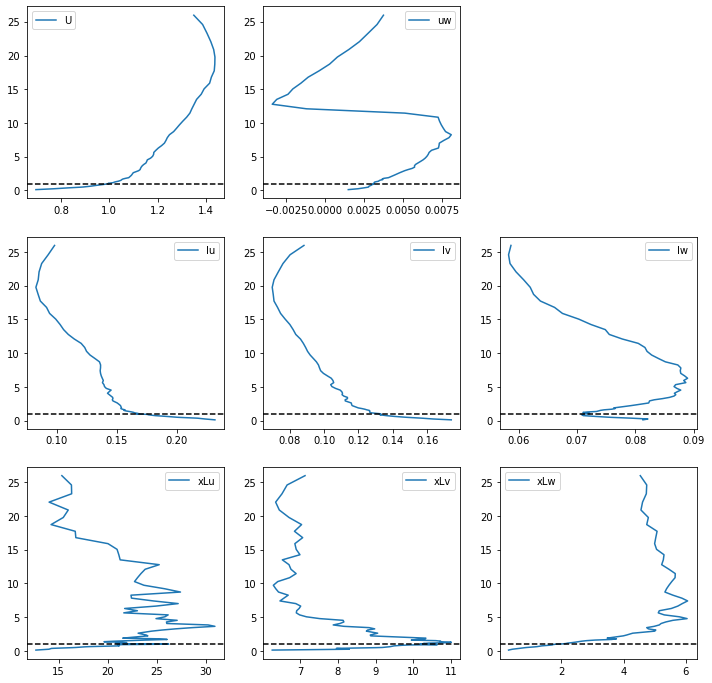

In [6]:
plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.plot(prof['U'], prof['Z'], label='U')
plt.axhline(1, color='k', linestyle='--')
plt.legend()

plt.subplot(3,3,2)
plt.plot(prof['uw'], prof['Z'], label='uw')
plt.axhline(1, color='k', linestyle='--')
plt.legend()

plt.subplot(3,3,4)
plt.plot(prof['Iu'], prof['Z'], label='Iu')
plt.axhline(1, color='k', linestyle='--')
plt.legend()

plt.subplot(3,3,5)
plt.plot(prof['Iv'], prof['Z'], label='Iv')
plt.axhline(1, color='k', linestyle='--')
plt.legend()

plt.subplot(3,3,6)
plt.plot(prof['Iw'], prof['Z'], label='Iw')
plt.axhline(1, color='k', linestyle='--')
plt.legend()

plt.subplot(3,3,7)
plt.plot(prof['xLu'], prof['Z'], label='xLu')
plt.axhline(1, color='k', linestyle='--')
plt.legend()

plt.subplot(3,3,8)
plt.plot(prof['xLv'], prof['Z'], label='xLv')
plt.axhline(1, color='k', linestyle='--')
plt.legend()

plt.subplot(3,3,9)
plt.plot(prof['xLw'], prof['Z'], label='xLw')
plt.axhline(1, color='k', linestyle='--')
plt.legend()

## Spectra

We have three spectra, all a function of frequency $f=nH/U_h$ at the reference height $H$. They are:
* Longitudinal spectral density, $nS_{uu}/\sigma_u^2$
* Transversal spectral density, $nS_{vv}/\sigma_v^2$
* Vertical spectral density, $nS_{ww}/\sigma_w^2$

All the spectra are normalized and a fixed size for the number of $f$ of 1000 is deemed sufficient. 

Text(0, 0.5, 'Sww')

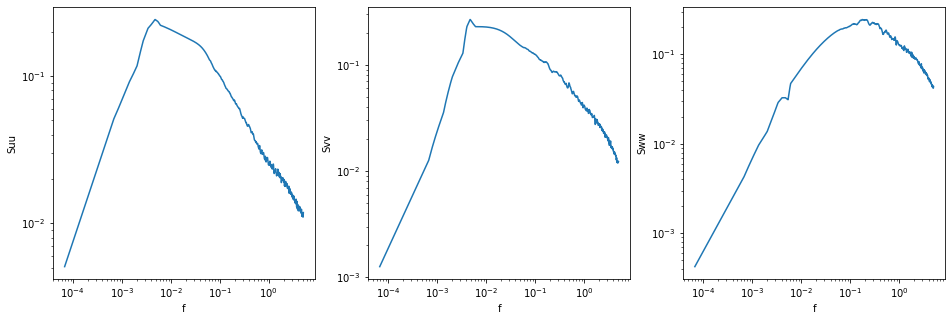

In [7]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.loglog(spect['f'], spect['Suu'], label='Suu')
plt.xlabel('f')
plt.ylabel('Suu')

plt.subplot(1,3,2)
plt.loglog(spect['f'], spect['Svv'], label='Svv')
plt.xlabel('f')
plt.ylabel('Svv')

plt.subplot(1,3,3)
plt.loglog(spect['f'], spect['Sww'], label='Sww')
plt.xlabel('f')
plt.ylabel('Sww')

## Cp time history
The Cp time history is the matrix containing the point-specific information that determines the final statistical results. 

**Caution**: The Cp time history from one point should never be handled 'together' in the explicit or implicit feature identification by the ML model. The Cp time history from one point should be handled as a single example. It may individually reshaped into a 2D matrix to handle it like an image.

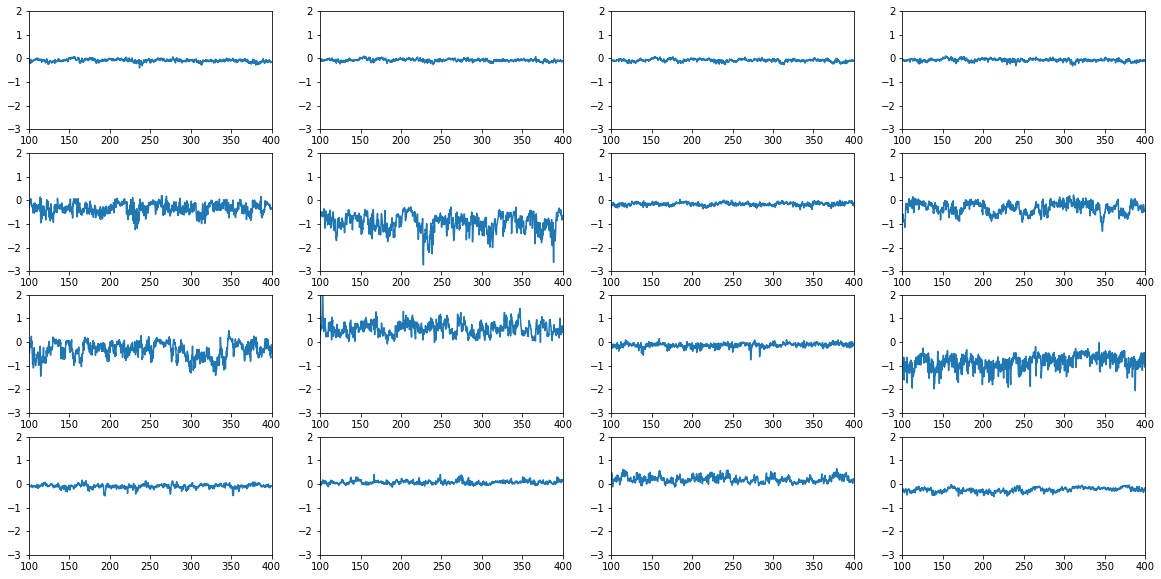

In [8]:
timeStep = 0.25
time = np.arange(0, cpTH.shape[1]*timeStep, timeStep)
timeRange = [100, 400]

idx = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
idx = [0, 14, 19, 36, 105, 178, 450, 532, 782, 790, 950, 1000, 1100, 1200, 1250, 1300,]

plt.figure(figsize=(20,10))

for i,ii in enumerate(idx):
    plt.subplot(4,4,i+1)
    iStart = int(timeRange[0]/timeStep)
    iEnd = int(timeRange[1]/timeStep)
    plt.plot(time[iStart:iEnd], cpTH[ii,iStart:iEnd], label=f'cpTH {i}')
    plt.xlim(timeRange)
    plt.ylim([-3, 2])

In image form:

(1320, 200, 200)


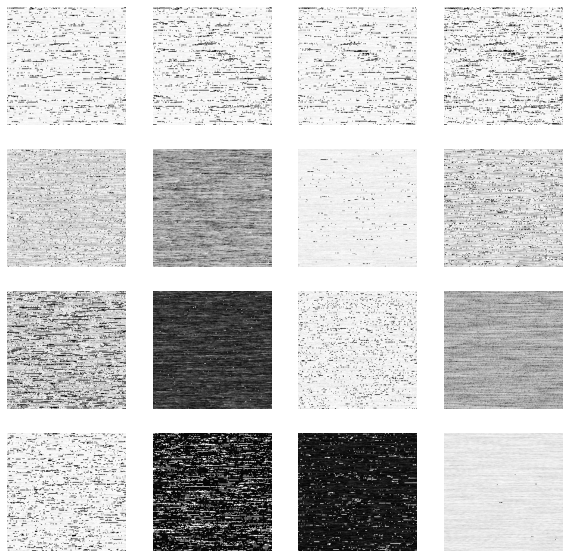

In [28]:
from PIL import Image

ishape = (cpTH.shape[0],200,200)
cpTH_im = cpTH.reshape(ishape)
print(cpTH_im.shape)

cpTH_im_norm = (cpTH_im * 255 / cpTH_im.max()).astype(np.uint8) # this is ONLY for visualization. The data is already normalized for the actual ML model.

plt.figure(figsize=(10,10))
for i, ii in enumerate(idx):
    ax = plt.subplot(4,4,i+1)
    ax.imshow(cpTH_im_norm[ii,:,:], cmap='gray')
    ax.axis('off')
    # plt.show()


# Outputs

## Cp statistics

The Cp statistics matrix contains:
* 'meanCp': The mean of Cp time history, $\overline{C}_p$, 
* 'stdCp': The standard deviation of Cp time history, $\tilde{C}_p$, 
* 'skewCp': The skewness of Cp time history, $\gamma_3$,
* 'kurtCp': The kurtosis of Cp time history, $\gamma_4$,
* 'mu_max': The location parameter of Gumbel distribution fitted to the maximum values, $\hat{\mu}$,
* 'sig_max': The scale parameter of Gumbel distribution fitted to the maximum values, $\hat{\sigma}$, 
* 'mu_min': The location parameter of Gumbel distribution fitted to the minimum values, $\check{\mu}$,
* 'sig_min': The scale parameter of Gumbel distribution fitted to the minimum values, $\check{\sigma}$, 

Extra statistics (the ML model will not predict these but they are the final practical results):
* 'minCp': The minimum peak value of Cp time history, $\check{C}_p$, 
* 'maxCp': The maximum peak value of Cp time history, $\hat{C}_p$, 

The mean, standard deviation, skewness, and kurtosis are calculated using the standard formulas.

The peak values (i.e., 'maxCp' and 'minCp') are calculated as the value of Cp corresponding to the 57.04% probability of non-exceedance. The probability of non-exceedance is calculated using the Gumbel distribution. The Gumbel distribution is a two-parameter family of continuous probability distributions. The PDF of Gumbel distribution for minimum and maximum are, respectively, given by:

$$f(x|\mu,\sigma)_{min} = \frac{1}{\sigma} \exp\left(\frac{x-\mu}{\sigma}\right) \exp\left(-\exp\left(\frac{x-\mu}{\sigma} \right) \right)$$ 
$$f(x|\mu,\sigma)_{max} = \frac{1}{\sigma} \exp\left(-\frac{x-\mu}{\sigma}\right) \exp\left(-\exp\left(-\frac{x-\mu}{\sigma} \right) \right)$$ 

where: 
* $x$ is the random variable
* $\mu$ is the location parameter
* $\sigma$ is the scale parameter



In [10]:
def gumbelPDF_min(x, mu, sigma):
    # print(f"mu: {mu}, sigma: {sigma}")
    beta = 1/sigma
    return beta*(np.exp(beta*(x-mu)) * np.exp(-np.exp(beta*(x-mu))))

def gumbelPDF_max(x, mu, sigma):
    # print(f"mu: {mu}, sigma: {sigma}")
    beta = 1/sigma
    return beta*(np.exp(-beta*(x-mu)) * np.exp(-np.exp(-beta*(x-mu))))
    

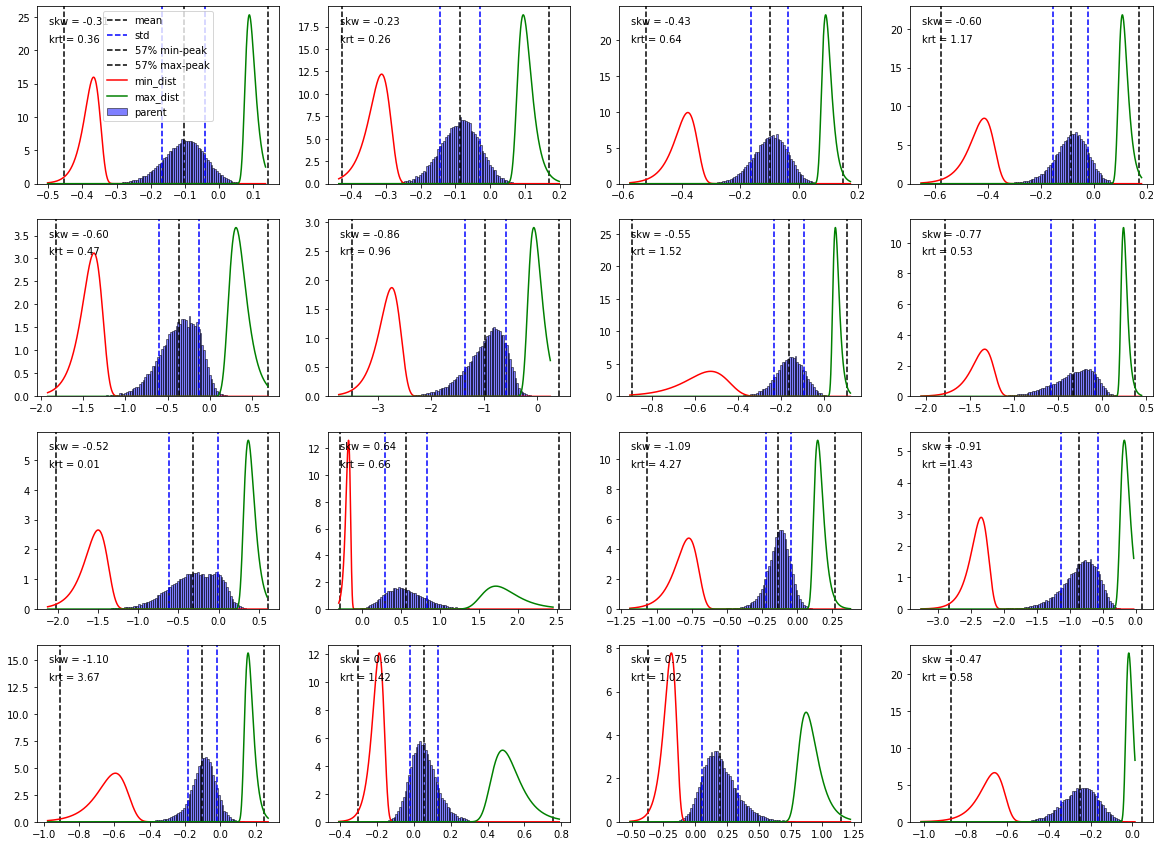

In [18]:
idx = [0, 14, 19, 36, 105, 178, 450, 532, 782, 790, 950, 1000, 1100, 1200, 1250, 1300,]

# x = np.linspace(-4, 3, 1000)

plt.figure(figsize=(20,15))

for i,ii in enumerate(idx):
    x = np.linspace(min(cpTH[ii,:])*1.2, max(cpTH[ii,:])*1.2, 1000)
    plt.subplot(4,4,i+1)
    plt.hist(cpTH[ii,:], bins=100, density=True, label='parent', alpha=0.5, color='b', edgecolor='k')
    plt.axvline(cpstats['meanCp'][ii], color='k', linestyle='--', label='mean')
    plt.axvline(cpstats['meanCp'][ii] + cpstats['stdCp'][ii], color='b', linestyle='--', label='std')
    plt.axvline(cpstats['meanCp'][ii] - cpstats['stdCp'][ii], color='b', linestyle='--')
    plt.axvline(cpstats['minCp'][ii], color='k', linestyle='--', label='57% min-peak')
    plt.axvline(cpstats['maxCp'][ii], color='k', linestyle='--', label='57% max-peak')
    plt.plot(x, -1*gumbelPDF_max(x, cpstats['mu_min'][ii], cpstats['sig_min'][ii]), label='min_dist', color='r')
    plt.plot(x, gumbelPDF_max(x, cpstats['mu_max'][ii], cpstats['sig_max'][ii]), label='max_dist', color='g')
    plt.text(0.05, 0.9, f'skw = {cpstats["skewCp"][ii]:.2f}', transform=plt.gca().transAxes, fontsize=10)
    plt.text(0.05, 0.8, f'krt = {cpstats["kurtCp"][ii]:.2f}', transform=plt.gca().transAxes, fontsize=10)
    # plt.xlim([-4, 3])
    if i == 0:
        plt.legend()

plt.show()


The sample outputs are shown in the above figure. The parent distribution is represented by the histogram. The mean, standard deviation, skewness, and kurtosis are also indicated. They are more stable representatives of the parent distribution.

Note: There seems to be a subtle error in the current results that I will fix for the next version. 